<a href="https://colab.research.google.com/github/sonasamsonova222-cmd/samssonya/blob/main/%D0%9D%D0%A1_%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%8218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==== УСТАНОВКА БИБЛИОТЕК (запусти эту ячейку один раз) ====
!pip install gymnasium[classic-control] --quiet
!pip install numpy matplotlib --quiet

import numpy as np
import tensorflow as tf
import collections
import random
import gymnasium as gym
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)


TensorFlow: 2.19.0
NumPy: 2.0.2


In [ ]:
# ==== РЕАЛИЗАЦИЯ DQN‑АГЕНТА С ГРАФИКАМИ ТОЧНОСТИ И ОШИБКИ ====

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        # Q‑network и target‑network
        self.q_network = self._build_q_network()
        self.target_network = self._build_q_network()
        self.target_network.set_weights(self.q_network.get_weights())

        # Replay buffer
        self.replay_buffer = collections.deque(maxlen=2000)

        # Гиперпараметры
        self.gamma = 0.99          # discount factor
        self.epsilon = 1.0         # exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def _build_q_network(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_size)
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mse'
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def act(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.q_network(state[np.newaxis]).numpy()[0]
        return int(np.argmax(q_values))

    def replay(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return None  # нет лосса для записи

        batch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = tf.convert_to_tensor(np.array(states), dtype=tf.float32)
        next_states = tf.convert_to_tensor(np.array(next_states), dtype=tf.float32)
        rewards = tf.convert_to_tensor(np.array(rewards), dtype=tf.float32)
        dones = tf.convert_to_tensor(np.array(dones, dtype=np.float32), dtype=tf.float32)

        next_q_values = self.target_network(next_states)
        max_next_q = tf.reduce_max(next_q_values, axis=1)
        target_q = rewards + self.gamma * max_next_q * (1.0 - dones)

        with tf.GradientTape() as tape:
            q_values = self.q_network(states)
            indices = tf.stack(
                [tf.range(batch_size), tf.convert_to_tensor(actions, dtype=tf.int32)],
                axis=1
            )
            chosen_q = tf.gather_nd(q_values, indices)
            loss = tf.keras.losses.MSE(target_q, chosen_q)

        grads = tape.gradient(loss, self.q_network.trainable_variables)
        self.q_network.optimizer.apply_gradients(zip(grads, self.q_network.trainable_variables))

        return float(tf.reduce_mean(loss).numpy())

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def train(self, env, episodes=100, batch_size=32, update_frequency=5):
        rewards_history = []
        loss_history = []
        accuracy_history = []

        for episode in range(episodes):
            state, _ = env.reset()
            done = False
            total_reward = 0
            total_steps = 0
            greedy_matches = 0  # для "точности" выбора действий

            episode_losses = []

            while not done:
                # действие по текущей epsilon‑greedy политике
                action = self.act(state, training=True)

                # «идеальное» greedy‑действие для оценки точности
                q_values = self.q_network(state[np.newaxis]).numpy()[0]
                greedy_action = int(np.argmax(q_values))
                if action == greedy_action:
                    greedy_matches += 1

                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                self.remember(state, action, reward, next_state, done)
                loss_value = self.replay(batch_size)
                if loss_value is not None:
                    episode_losses.append(loss_value)

                state = next_state
                total_reward += reward
                total_steps += 1

            if episode % update_frequency == 0:
                self.update_target_network()

            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            rewards_history.append(total_reward)
            mean_loss = np.mean(episode_losses) if episode_losses else 0.0
            loss_history.append(mean_loss)
            accuracy = greedy_matches / max(total_steps, 1)
            accuracy_history.append(accuracy)

            print(
                f"Episode {episode + 1}/{episodes}, "
                f"reward={total_reward}, "
                f"loss={mean_loss:.4f}, "
                f"accuracy={accuracy:.3f}, "
                f"epsilon={self.epsilon:.3f}"
            )

        # --- Визуализация трёх графиков ---
        fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

        axs[0].plot(rewards_history)
        axs[0].set_ylabel("Reward")
        axs[0].set_title("Reward per episode")
        axs[0].grid(True)

        axs[1].plot(loss_history)
        axs[1].set_ylabel("Loss")
        axs[1].set_title("Average loss per episode")
        axs[1].grid(True)

        axs[2].plot(accuracy_history)
        axs[2].set_ylabel("Accuracy")
        axs[2].set_xlabel("Episode")
        axs[2].set_title("Greedy-action accuracy per episode")
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()


Episode 1/100, reward=15.0, loss=0.0000, accuracy=0.533, epsilon=0.995
Episode 2/100, reward=11.0, loss=0.0000, accuracy=0.636, epsilon=0.990
Episode 3/100, reward=23.0, loss=0.8018, accuracy=0.522, epsilon=0.985
Episode 4/100, reward=15.0, loss=0.3832, accuracy=0.400, epsilon=0.980
Episode 5/100, reward=26.0, loss=0.1394, accuracy=0.538, epsilon=0.975
Episode 6/100, reward=38.0, loss=0.0460, accuracy=0.447, epsilon=0.970
Episode 7/100, reward=13.0, loss=0.6406, accuracy=0.615, epsilon=0.966
Episode 8/100, reward=58.0, loss=0.1146, accuracy=0.466, epsilon=0.961
Episode 9/100, reward=15.0, loss=0.0646, accuracy=0.533, epsilon=0.956
Episode 10/100, reward=13.0, loss=0.0630, accuracy=0.692, epsilon=0.951
Episode 11/100, reward=17.0, loss=0.0886, accuracy=0.647, epsilon=0.946
Episode 12/100, reward=25.0, loss=0.4295, accuracy=0.520, epsilon=0.942
Episode 13/100, reward=10.0, loss=0.2267, accuracy=0.600, epsilon=0.937
Episode 14/100, reward=83.0, loss=0.1840, accuracy=0.542, epsilon=0.932
E

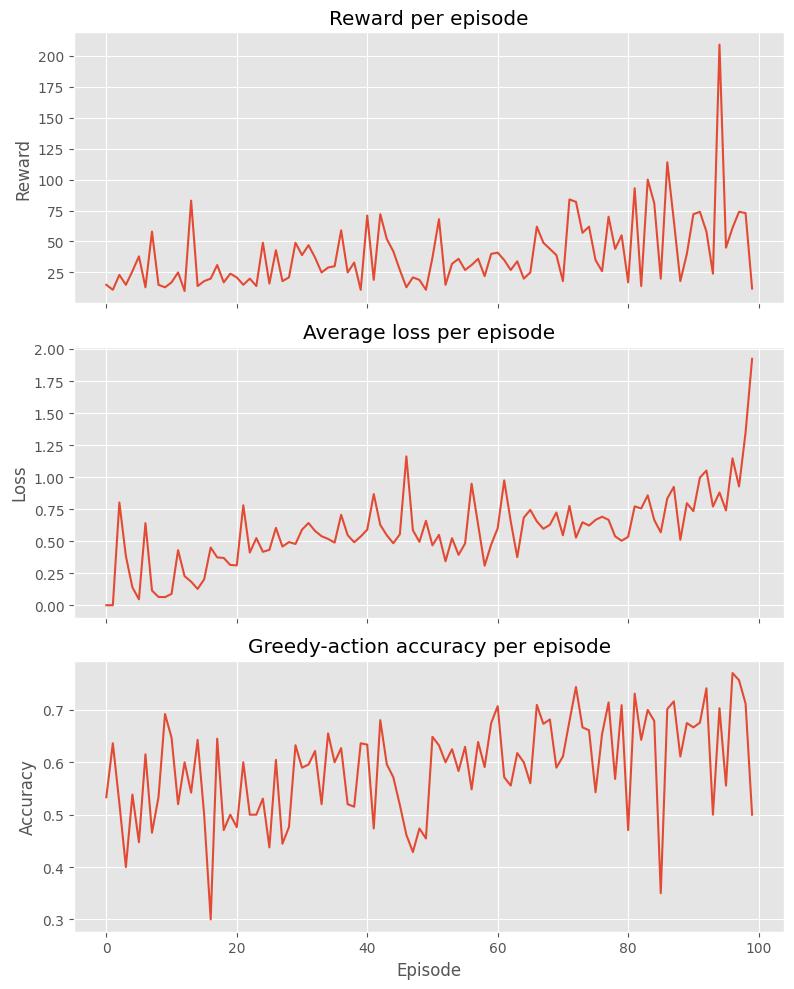

In [ ]:
# ==== ЗАПУСК ОБУЧЕНИЯ НА CartPole-v1 ====

env = gym.make("CartPole-v1")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size, learning_rate=0.001)
agent.train(env, episodes=100, batch_size=32, update_frequency=5)

env.close()
